In [ ]:
import sys
import numpy as np
import torch # tested under pytorch 0.4.0
import math
%matplotlib inline
import matplotlib.pyplot as plt

torch.manual_seed(1) # Fix seed of the random number generators
np.random.seed(1)

In [2]:
def show_imgs(imgs,l1=4,l2=5,s1=6,s2=6):
    """    Plot images    """
    plt.rcParams['figure.figsize']=(s1,s2)
    imgs=imgs.reshape([-1,28,28])
    g, ax = plt.subplots(l1,l2)
    for i in range(l1):
        for j in range(l2):
            a=i*l1+j
            if(a>=imgs.shape[0]):
                break
            ax[i][j].imshow(imgs[a,:,:],cmap='summer')
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])
    plt.show()

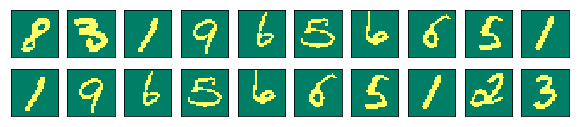

In [3]:
n = 784
m = 20
data = np.load("imgs/mnist_100_28x28_p0.5.npy")
data = data[:m, :, :]
data = torch.LongTensor(data)
data = data.view(-1, 784)
show_imgs(data, 2, 10, 10, 2)

In [4]:
Dmax = 30
bond_dims = [Dmax for i in range(n-1)] + [1]
tensors = [torch.randn(bond_dims[-1], 2, 10, bond_dims[0])] + [torch.randn(bond_dims[i-1], 2, bond_dims[i]) for i in range(1, n)]

## 1 - Building blocks of the Model

## 1.1 - Forward
\begin{align*}
&f^{l}(x) = \frac{1}{m}\sum_{i}{[A^{s_{1}}_{\alpha_{0}\alpha_{1}}\cdots A^{s_{n}}_{\alpha_{n-1}\alpha_{n}}\Phi^{s_{1}s_{2}\cdots s_{n}}(x^{i})]}\\
&L = \frac{1}{m}\sum_{i}{[f^{l}(x_{i}) - \delta^{l}_{n}]^{2}}
\end{align*}

In [6]:
def tensor_initialize(parameters):
    """
    Initialize the tensor network.
    
    Arguments:
    paramters -- python dictionary containing:
                    m -- Number of samples in one batch
                    n -- Number of features
                    Dmax -- Bond dimensions
                    l -- Sites of the output tensor
    
    Returns:
    tensors -- MPS, list of pytorch tensors
    """
    m, n, Dmax, l = parameters['m'], parameters['n'], parameters['Dmax'], parameters['l']
    bond_dims = [Dmax for i in range(n - 1)] + [1]
    tensors = []
    for i in range(n):
        if i != l:
            tensors.append(torch.randn(bond_dims[i-1], 2, bond_dims[i]))
        else:
            tensors.append(torch.randn(bond_dims[i-1], 2, 10, bond_dims[i]))
    return tensors

In [5]:
def tnn_forward(x, l, tensors):
    m, n = x.shape
    psi = torch.ones([m, 1, 1])

    for site in range(n):
        if site < l:
            psi = psi @ tensors[site][:, x[:, site], :].permute(1, 0, 2)
        elif site == l:
            left_psi = psi
            right_psi = torch.ones([m, tensors[l].shape[3], tensors[l].shape[3]])
            psi = psi @ tensors[site][:, x[:, site], :, :].permute(2, 1, 0, 3)
        else:
            right_psi = right_psi @ tensors[site][:, x[:, site], :].permute(1, 0, 2)
            psi = psi @ tensors[site][:, x[:, site], :].permute(1, 0, 2)
            
    cache = (left_psi, right_psi, x, tensors, psi)  
    return psi, cache

In [7]:
#test for the tensor_initialize() 
torch.manual_seed(1)
m, n, l = 5, 10, 6
Dmax = 5
parameters = {'m': m, 'n': n, 'Dmax': Dmax, 'l': l}
bond_dims = [Dmax for i in range(n-1)] + [1]
#tensors = [torch.randn(bond_dims[-1], 2, 10, bond_dims[0])] + [torch.randn(bond_dims[i-1], 2, bond_dims[i]) for i in range(1, n)]
tensors = tensor_initialize(parameters)
print(len(tensors))
print(tensors[l].shape)
print(tensors[0].shape)
print(tensors[n-1].shape)

10
torch.Size([5, 2, 10, 5])
torch.Size([1, 2, 5])
torch.Size([5, 2, 1])


In [8]:
#test for tnn_forward() module
x = torch.randint(1, (m, n))
psi, cache = tnn_forward(x, l, tensors)
(left_psi, right_psi) = cache
print(psi.shape)
print(left_psi.shape)
print(right_psi.shape)

torch.Size([10, 5, 1, 1])
torch.Size([5, 1, 5])
torch.Size([5, 5, 1])


## 1.2 - Backward
\begin{align*}
&\frac{\partial{L}}{\partial{f^{l}(x^{(i)})}} = 2(f^{l}(x_{i}) - \delta^{l}_{n})\\
&\frac{\partial{f^{l}(x^{(i)})}}{\partial{A^{l}_{\alpha_{k-1}\alpha_{k}}}} = \tilde{A}^{s_{1}s_{2}\cdots s_{l-1}}_{\alpha_{k-1}}\tilde{B}^{s_{l+1}\cdots s_{n}}_{\alpha_{k}}\Phi^{s_{1}s_{2}\cdots s_{n}}(x^{(i)})
\end{align*}

In [17]:
def tnn_cell_backward(caches, Y):
    """
    Calculate the gradients of the loss function wrt mps.
    
    Arguments:
    Y -- labels of the samples, pytorch tensor with dimension (m, index)
    
    Return:
    dAl -- gradient of the tensor, pytorch tensor with dimension (m, index, alpha_lf, alpha_rig)
    
    
    """
    left_psi, right_psi, x, tensors, psi = cache
    dfl = 2 * (psi - Y)
    dAl = dfl * (left_psi.transpose(1, 2) @ right_psi.transpose(1, 2))
    
    return dAl

In [ ]:
#test for tnn_cell_backward() module


In [9]:
x = torch.zeros(2, 3, 4)

In [12]:
x.transpose(1, 2).shape

torch.Size([2, 4, 3])

In [13]:
2 * torch.ones(1, 2)

tensor([[2., 2.]])

In [14]:
x = torch.ones(5, 2, 2)
y = torch.ones(10, 5, 1, 1)

In [16]:
(x * y).shape

torch.Size([10, 5, 2, 2])

In [68]:
def one_hot(Y, index):
    """
    encode the label of the training set as one hot vector.
    
    Arguments:
    Y -- labels of the samples, numpy vector with dimension as (m, 1)
    
    Return:
    Y_onehot -- labels of the samples, pytorch tensor with dimension as (m, index)
    """
    m = Y.shape[0]
    Y_onehot = torch.zeros(m, index, dtype=torch.int32).scatter_(1, torch.LongTensor(Y.reshape(m, 1)), torch.ones(m, index, dtype=torch.int32))
    
    return Y_onehot

In [70]:
#test for module one_hot()
m, index = 10, 10
Y = np.random.binomial(index, 0.5, m)
Y_onehot = one_hot(Y, index)
print(Y)
print(Y_onehot)

[2 2 2 4 7 5 5 7 3 4]
tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=torch.int32)
